In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nahueltools import *

In [180]:
movies       = pd.read_csv("../movies.csv", index_col=0)
interactions = pd.read_csv("../interactions.csv", index_col=0)

In [181]:
movies = movies.set_index("movieId")

In [182]:
movies.Title.nunique()

4750

In [183]:
interactions["Title"] = movies.loc[interactions.movieId, "Title"].to_numpy()
popularity = interactions.groupby("Title")["movieId"].count().sort_values(ascending = False)
popularity.value_counts()

movieId
1      1179
2       577
3       410
4       308
5       208
       ... 
307       1
108       1
145       1
78        1
329       1
Name: count, Length: 153, dtype: int64

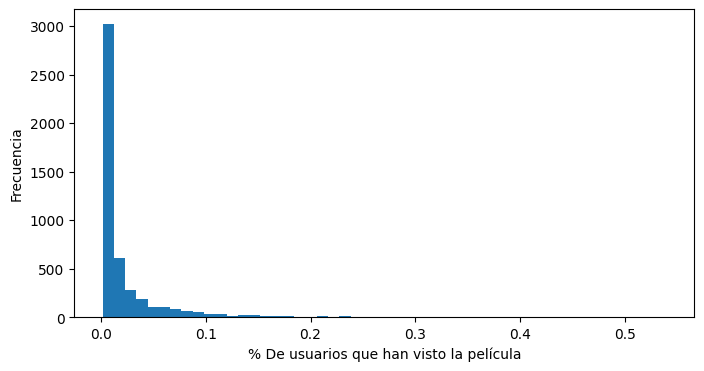

In [217]:
plt.figure(figsize = (8, 4))
plt.hist(popularity/610, bins = 50)
plt.xlabel("% De usuarios que han visto la película")
plt.ylabel("Frecuencia")
pass

In [220]:
popularity[popularity<6].index[60:]

Index(['ghosts of mars', 'whip it', 'pcu', 'ghost rider: spirit of vengeance',
       'alien: covenant', 'wild hogs', 'paranormal activity 2', 'wind river',
       'out cold', 'leap year',
       ...
       'remember me', 'executive suite', 'reign of assassins', 'exodus',
       'redline', 'redbelt', 'red tails', 'red state', 'red river', ''71'],
      dtype='object', name='Title', length=2622)

In [186]:
max_time = 1514764800
min_time = 946684800

(array([47.,  8.,  1., 23., 10.,  5.,  7.,  8.,  6., 15.,  8.,  9.,  5.,
         3.,  9.,  4.,  3., 16., 12., 16.]),
 array([8.29322340e+08, 8.64641706e+08, 8.99961073e+08, 9.35280439e+08,
        9.70599805e+08, 1.00591917e+09, 1.04123854e+09, 1.07655790e+09,
        1.11187727e+09, 1.14719664e+09, 1.18251600e+09, 1.21783537e+09,
        1.25315474e+09, 1.28847410e+09, 1.32379347e+09, 1.35911283e+09,
        1.39443220e+09, 1.42975157e+09, 1.46507093e+09, 1.50039030e+09,
        1.53570967e+09]),
 <BarContainer object of 20 artists>)

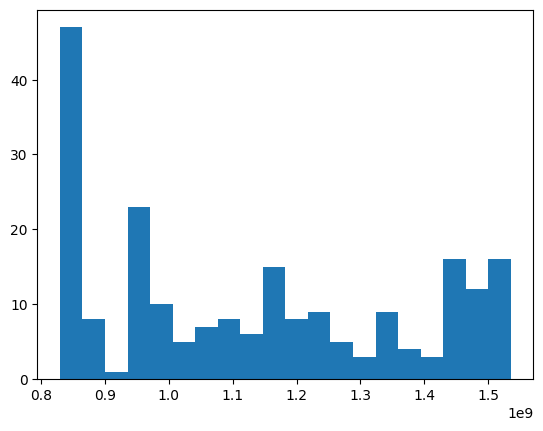

In [187]:
plt.hist(interactions[interactions.movieId == 1].timestamp, bins=20)

In [236]:
n_bins = 30

density_matrix = []
movie_ids = []

for movie_id in movies.index:
    timestamps = interactions[interactions.movieId == movie_id].timestamp
    if len(timestamps) >= 6:
        X, y =gaussian_density(timestamps, range =[min_time, max_time], sigma_ratio = 0.05, bins = n_bins)
        density_matrix.append(y)
        movie_ids.append(movie_id)
    
density_matrix = np.array(density_matrix)
movie_ids = np.array(movie_ids)
density_matrix /= np.expand_dims(density_matrix.sum(1), 1)

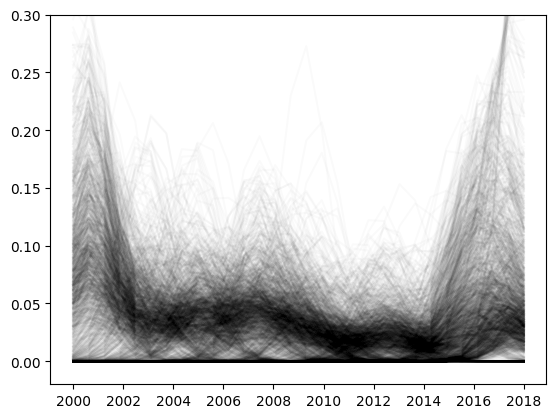

In [237]:
plt.plot(pd.to_datetime(X, unit="s"), density_matrix.T, color = "k", alpha = 0.02)
plt.ylim([-0.02, 0.3])
plt
pass

In [238]:
from sklearn.cluster import KMeans

km = KMeans(6)

In [239]:
clusters3 = km.fit_predict(density_matrix)

C:\ProgramData\Miniconda3\envs\datamining\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [240]:
from sklearn.manifold import TSNE

tsne3 = TSNE(2)

In [241]:
dims3 = tsne.fit_transform(density_matrix)

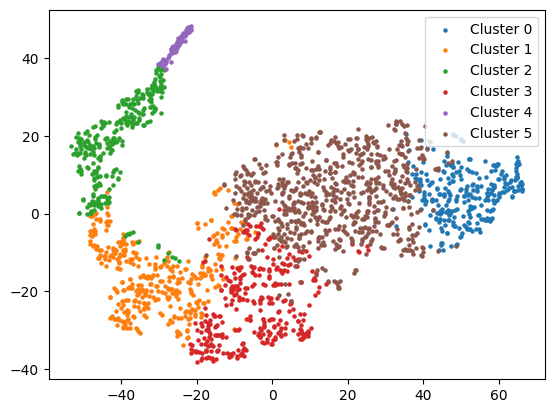

In [242]:
for cluster in range(6):
    plt.scatter(*dims3[clusters3 == cluster].T, s=5, label = f"Cluster {cluster}")
    
plt.legend()

Text(0.5, 1.0, 'Reducción de dimensión de películas')

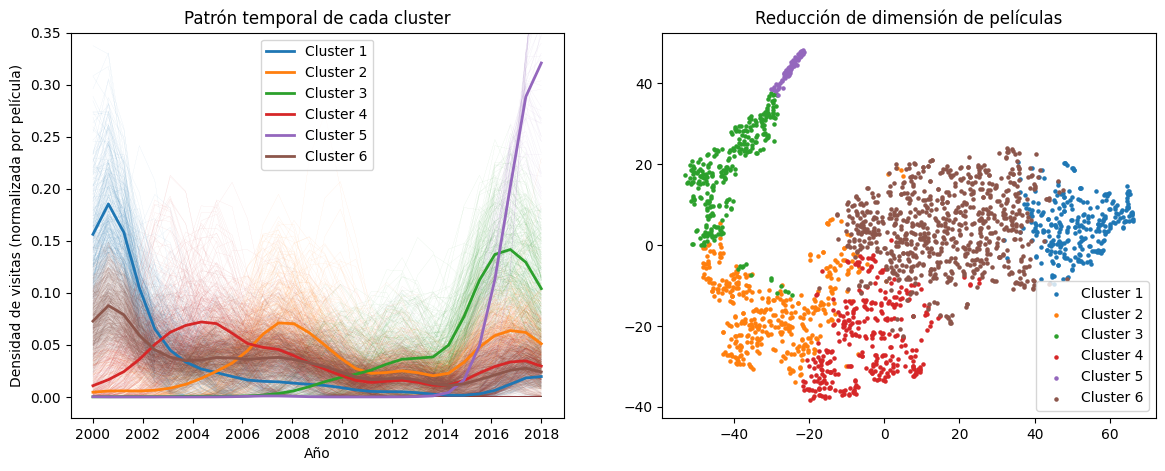

In [248]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

density_matrix_norm = density_matrix / np.sum(density_matrix, 0)

for cluster, color in zip(range(6), colors):
    clustermovies = density_matrix[clusters3 == cluster]
    ax1.plot(pd.to_datetime(X, unit="s"), clustermovies.T, color = color,
             alpha = 0.5, linewidth = 0.05)
for cluster, color in zip(range(6), colors):
    clustermovies = density_matrix[clusters3 == cluster]
    ax1.plot(pd.to_datetime(X, unit="s"), clustermovies.mean(0), linewidth = 2, 
             color = color, label = f"Cluster {cluster+1}")
    
ax1.set_xlabel("Año")
ax1.set_ylabel("Densidad de visitas (normalizada por película)")
ax1.set_ylim([-0.02, 0.35])
ax1.legend()
ax1.set_title("Patrón temporal de cada cluster")

for cluster in range(6):
    ax2.scatter(*dims3[clusters3 == cluster].T, s=5, label = f"Cluster {cluster+1}")
    
ax2.legend()
ax2.set_title("Reducción de dimensión de películas")

In [199]:
movies.loc[movie_ids[clusters == 4]].Title

movieId
137857.0                            the jungle book
122904.0                                   deadpool
152081.0                                   zootopia
152077.0                        10 cloverfield lane
136864.0         batman v superman: dawn of justice
122920.0                 captain america: civil war
158238.0                              the nice guys
122924.0                          x-men: apocalypse
159093.0                           now you see me 2
157296.0                               finding dory
135569.0                           star trek beyond
135536.0                              suicide squad
168250.0                                    get out
168252.0                                      logan
176371.0                          blade runner 2049
122916.0                             thor: ragnarok
177765.0                                       coco
179819.0                   star wars: the last jedi
174055.0                                    dunkirk
1351

In [249]:
pd.Series(clusters3).value_counts()

5    723
1    388
3    327
0    287
2    280
4     55
Name: count, dtype: int64

In [205]:
n_bins = 30

density_matrix2 = np.zeros((movies.shape[0], n_bins))
movie_ids2 = []

for i, movie_id in enumerate(movies.index):
    timestamps = interactions[interactions.movieId == movie_id].timestamp
    X, y =gaussian_density(timestamps, range =[min_time, max_time], sigma_ratio = 0.05, bins = n_bins)
    density_matrix2[i] = y

In [206]:
clusters2 = km.fit_predict(density_matrix2)

C:\ProgramData\Miniconda3\envs\datamining\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [208]:
dims2 = tsne.fit_transform(density_matrix2)

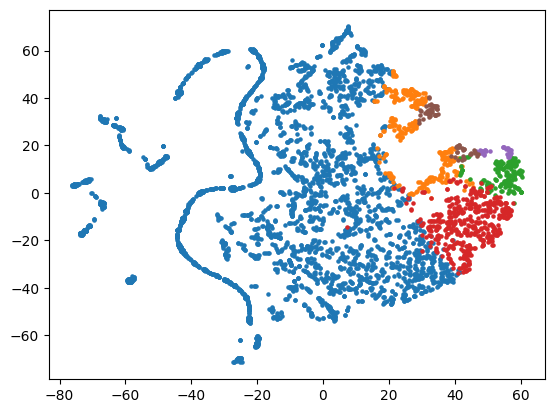

In [209]:
for cluster in range(6):
    plt.scatter(*dims2[clusters2 == cluster].T, s=5, label = f"Cluster {cluster}")

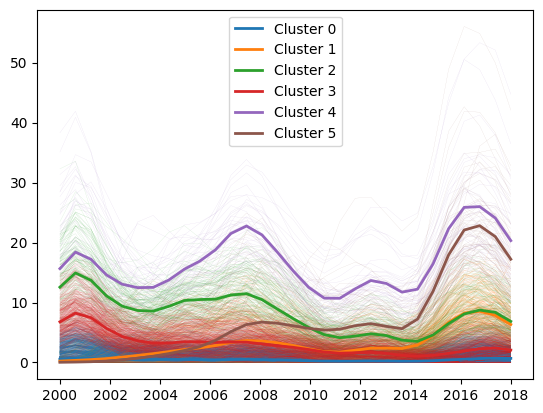

In [211]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for cluster, color in zip(range(6), colors):
    clustermovies = density_matrix2[clusters2 == cluster]
    plt.plot(pd.to_datetime(X, unit="s"), clustermovies.T, color = color,
             alpha = 0.4, linewidth = 0.1)
for cluster, color in zip(range(6), colors):
    clustermovies = density_matrix2[clusters2 == cluster]
    plt.plot(pd.to_datetime(X, unit="s"), clustermovies.mean(0), linewidth = 2, 
             color = color, label = f"Cluster {cluster}")
    
plt.legend()

In [235]:
clusters == 3

array([False, False, False, ..., False, False, False])